<a href="https://colab.research.google.com/github/MatheuxGualter/TelecomX/blob/main/TelecomX_BR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#📌 Extracão

In [ ]:
import requests
import pandas as pd

api = "https://raw.githubusercontent.com/alura-cursos/challenge2-data-science/main/TelecomX_Data.json"

retorno = requests.get(api)
retorno.raise_for_status()

data = retorno.json()
df = pd.DataFrame(data)

#🔧 Transformação

In [ ]:
import numpy as np

# Verificação de Valores Ausentes
print(df.isnull().sum())

customerID    0
Churn         0
customer      0
phone         0
internet      0
account       0
dtype: int64


In [ ]:
flattened_data = []
for item in data:
    flat_row = {
        'customerID': item.get('customerID'),
        'Churn': item.get('Churn'),
        'gender': item.get('customer', {}).get('gender'),
        'SeniorCitizen': item.get('customer', {}).get('SeniorCitizen'),
        'Partner': item.get('customer', {}).get('Partner'),
        'Dependents': item.get('customer', {}).get('Dependents'),
        'tenure': item.get('customer', {}).get('tenure'),
        'PhoneService': item.get('phone', {}).get('PhoneService'),
        'MultipleLines': item.get('phone', {}).get('MultipleLines'),
        'InternetService': item.get('internet', {}).get('InternetService'),
        'OnlineSecurity': item.get('internet', {}).get('OnlineSecurity'),
        'OnlineBackup': item.get('internet', {}).get('OnlineBackup'),
        'DeviceProtection': item.get('internet', {}).get('DeviceProtection'),
        'TechSupport': item.get('internet', {}).get('TechSupport'),
        'StreamingTV': item.get('internet', {}).get('StreamingTV'),
        'StreamingMovies': item.get('internet', {}).get('StreamingMovies'),
        'Contract': item.get('account', {}).get('Contract'),
        'PaperlessBilling': item.get('account', {}).get('PaperlessBilling'),
        'PaymentMethod': item.get('account', {}).get('PaymentMethod'),
        'Charges.Monthly': item.get('account', {}).get('Charges', {}).get('Monthly'),
        'Charges.Total': item.get('account', {}).get('Charges', {}).get('Total')
    }
    flattened_data.append(flat_row)

df = pd.DataFrame(flattened_data)

print("\nPrimeiras 5 linhas do DataFrame após achatamento:")
print(df.head())


Primeiras 5 linhas do DataFrame após achatamento:
   customerID Churn  gender  SeniorCitizen Partner Dependents  tenure  \
0  0002-ORFBO    No  Female              0     Yes        Yes       9   
1  0003-MKNFE    No    Male              0      No         No       9   
2  0004-TLHLJ   Yes    Male              0      No         No       4   
3  0011-IGKFF   Yes    Male              1     Yes         No      13   
4  0013-EXCHZ   Yes  Female              1     Yes         No       3   

  PhoneService MultipleLines InternetService  ... OnlineBackup  \
0          Yes            No             DSL  ...          Yes   
1          Yes           Yes             DSL  ...           No   
2          Yes            No     Fiber optic  ...           No   
3          Yes            No     Fiber optic  ...          Yes   
4          Yes            No     Fiber optic  ...           No   

  DeviceProtection TechSupport StreamingTV StreamingMovies        Contract  \
0               No         Yes     

In [ ]:
# Tratar 'Charges.Total' e 'Charges.Monthly' (garantir que sejam numéricos)
df['Charges.Total'] = df['Charges.Total'].replace(r'^\s*$', np.nan, regex=True)
df['Charges.Total'] = pd.to_numeric(df['Charges.Total'], errors='coerce')

df.dropna(subset=['Charges.Total'], inplace=True) # Remove NAs de Charges.Total
df['Charges.Monthly'] = pd.to_numeric(df['Charges.Monthly'], errors='coerce')

In [ ]:
# Criar 'Cobrancas_Diarias'
if 'Cobrancas_Diarias' not in df.columns:
    df['Cobrancas_Diarias'] = df['Charges.Monthly'] / 30

In [ ]:
# Corrigindo 'Churn' antes do renomeamento
if 'Churn' in df.columns:
    # Mapeia 'Yes' para 1, 'No' para 0. Outros valores (e NaNs) virarão NaN.
    df['Churn'] = df['Churn'].replace({'Yes': 1, 'No': 0, 'No internet service': np.nan, 'No phone service': np.nan})
    df['Churn'] = pd.to_numeric(df['Churn'], errors='coerce')

    # Remover linhas onde 'Churn' é NaN antes de converter para int ---
    initial_churn_nan_rows = df['Churn'].isnull().sum()
    if initial_churn_nan_rows > 0:
        print(f"Detectados {initial_churn_nan_rows} NaNs na coluna 'Churn'. Removendo linhas...")
        df.dropna(subset=['Churn'], inplace=True)

    df['Churn'] = df['Churn'].astype(int)

else:
    print("AVISO: Coluna 'Churn' não encontrada para mapeamento inicial.")

Detectados 224 NaNs na coluna 'Churn'. Removendo linhas...


In [ ]:
# Padronizar "No phone service" e "No internet service" para "No"
df['MultipleLines'] = df['MultipleLines'].replace('No phone service', 'No')
internet_service_features_orig = [
    'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
    'TechSupport', 'StreamingTV', 'StreamingMovies'
]
for col in internet_service_features_orig:
    if col in df.columns:
        df[col] = df[col].replace('No internet service', 'No')


# Mapear outras colunas binárias para 0/1 após a padronização 'No service' -> 'No'
binary_cols_map_to_01 = [
    'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling',
    'MultipleLines', 'OnlineSecurity', 'OnlineBackup',
    'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies'
]
for col in binary_cols_map_to_01:
    if col in df.columns and df[col].dtype == 'object':
        df[col] = df[col].map({'Yes': 1, 'No': 0})

# Tratar Genero separadamente 'Female'/'Male'
if 'gender' in df.columns and df['gender'].dtype == 'object':
    df['gender'] = df['gender'].map({'Female': 1, 'Male': 0})

# Tratar SeniorCitizen, que vem como int 0/1 e deve permanecer assim
if 'SeniorCitizen' in df.columns:
    df['SeniorCitizen'] = df['SeniorCitizen'].astype(int)

In [ ]:
# Renomear Colunas
new_column_names = {
    'customerID': 'ID_Cliente',
    'Churn': 'Evasao',
    'gender': 'Genero',
    'SeniorCitizen': 'Cidadao_Senior',
    'Partner': 'Parceiro',
    'Dependents': 'Dependentes',
    'tenure': 'Meses_Contrato',
    'PhoneService': 'Servico_Telefone',
    'MultipleLines': 'Multiplas_Linhas',
    'InternetService': 'Servico_Internet',
    'OnlineSecurity': 'Seguranca_Online',
    'OnlineBackup': 'Backup_Online',
    'DeviceProtection': 'Protecao_Dispositivo',
    'TechSupport': 'Suporte_Tecnico',
    'StreamingTV': 'Streaming_TV',
    'StreamingMovies': 'Streaming_Filmes',
    'Contract': 'Tipo_Contrato',
    'PaperlessBilling': 'Fatura_Online',
    'PaymentMethod': 'Metodo_Pagamento',
    'Charges.Monthly': 'Cobrancas_Mensais',
    'Charges.Total': 'Cobrancas_Totais',
    'Cobrancas_Diarias': 'Cobrancas_Diarias'
}
df.rename(columns=new_column_names, inplace=True)

In [ ]:
# Verificação e Remoção de Registros Duplicados
df.drop_duplicates(inplace=True)
df.drop_duplicates(subset=['ID_Cliente'], inplace=True)
print(f"Linhas duplicadas e IDs de clientes duplicados removidos. Linhas finais: {df.shape[0]}")

Linhas duplicadas e IDs de clientes duplicados removidos. Linhas finais: 7032


#📊 Carga e análise

In [ ]:
print("\Estatísticas Descritivas para Colunas Numéricas:")

# Seleciona apenas colunas numéricas
numeric_cols = df.select_dtypes(include=np.number).columns
if len(numeric_cols) > 0:
    print(df[numeric_cols].describe())
else:
    print("Nenhuma coluna numérica encontrada para análise descritiva.")

\Estatísticas Descritivas para Colunas Numéricas:
            Evasao       Genero  Cidadao_Senior     Parceiro  Dependentes  \
count  7032.000000  7032.000000     7032.000000  7032.000000  7032.000000   
mean      0.265785     0.495307        0.162400     0.482509     0.298493   
std       0.441782     0.500014        0.368844     0.499729     0.457629   
min       0.000000     0.000000        0.000000     0.000000     0.000000   
25%       0.000000     0.000000        0.000000     0.000000     0.000000   
50%       0.000000     0.000000        0.000000     0.000000     0.000000   
75%       1.000000     1.000000        0.000000     1.000000     1.000000   
max       1.000000     1.000000        1.000000     1.000000     1.000000   

       Meses_Contrato  Servico_Telefone  Multiplas_Linhas  Seguranca_Online  \
count     7032.000000       7032.000000       7032.000000       7032.000000   
mean        32.421786          0.903299          0.421928          0.286547   
std         24.5452

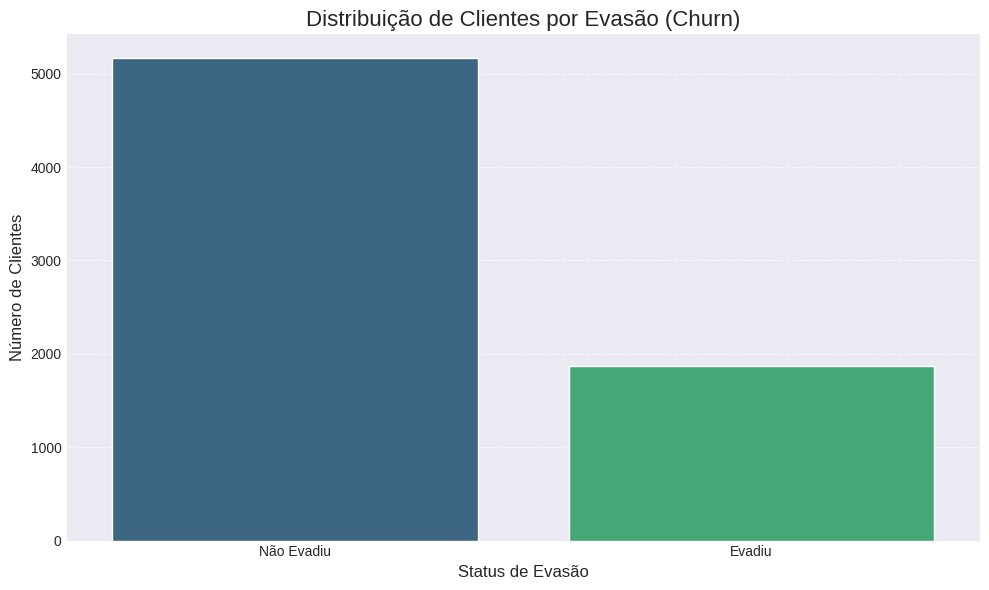

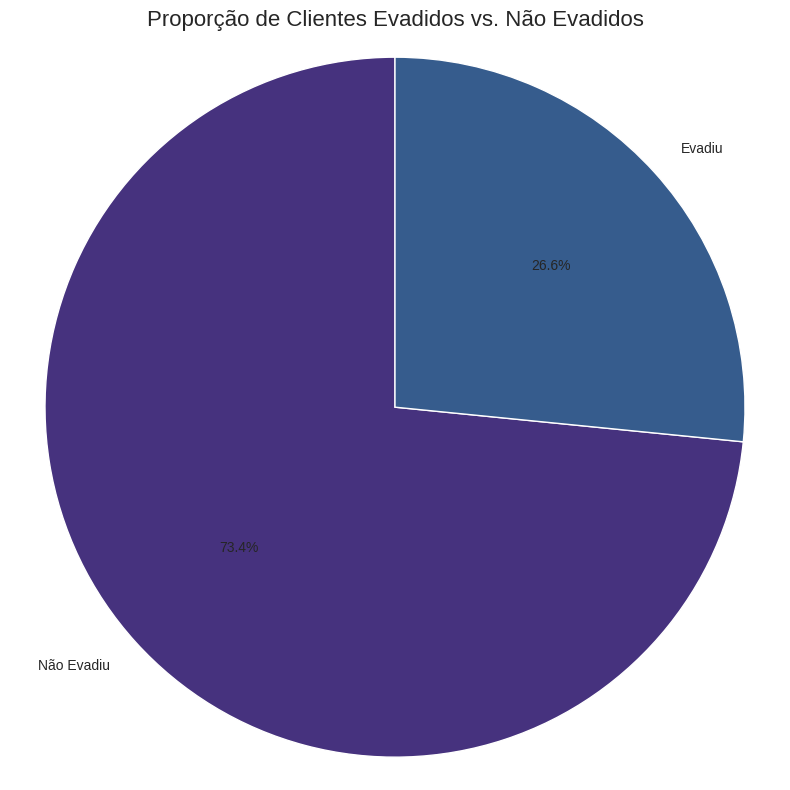

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculando as contagens e proporções
if not df.empty and 'Evasao' in df.columns and len(df['Evasao'].unique()) > 1:
    churn_counts = df['Evasao'].value_counts()
    churn_proportions = df['Evasao'].value_counts(normalize=True) * 100

    churn_df = pd.DataFrame({'Contagem': churn_counts, 'Proporção (%)': churn_proportions})
    churn_df.index = churn_df.index.map({0: 'Não Evadiu', 1: 'Evadiu'})

    # Gráfico de Barras
    plt.figure(figsize=(10, 6))
    sns.barplot(x=churn_df.index, y='Contagem', data=churn_df, palette='viridis', hue=churn_df.index, legend=False)
    plt.title('Distribuição de Clientes por Evasão (Churn)', fontsize=16)
    plt.xlabel('Status de Evasão', fontsize=12)
    plt.ylabel('Número de Clientes', fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    # Gráfico de Pizza
    plt.figure(figsize=(8, 8))
    plt.pie(churn_proportions, labels=churn_df.index, autopct='%1.1f%%', colors=sns.color_palette('viridis'), startangle=90)
    plt.title('Proporção de Clientes Evadidos vs. Não Evadidos', fontsize=16)
    plt.axis('equal')
    plt.tight_layout()
    plt.show()
else:
    print("\nNão foi possível gerar os gráficos.")

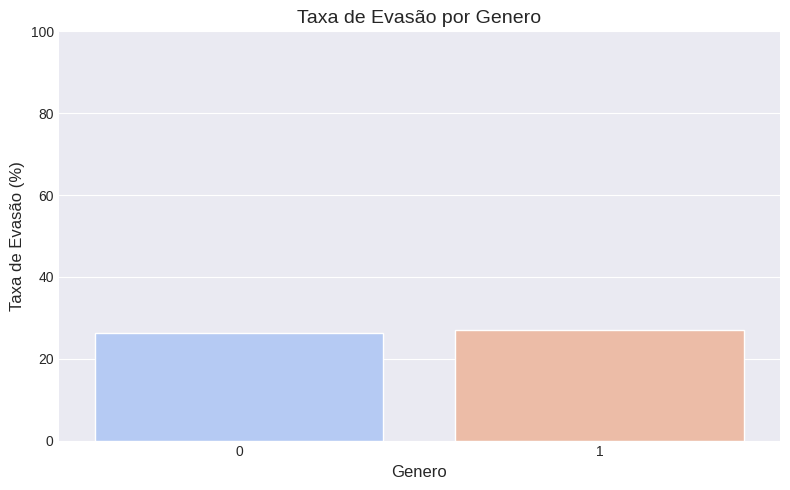

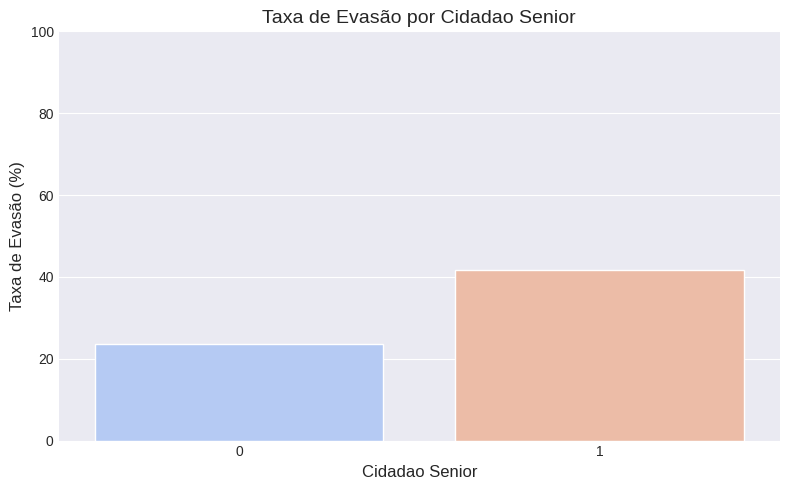

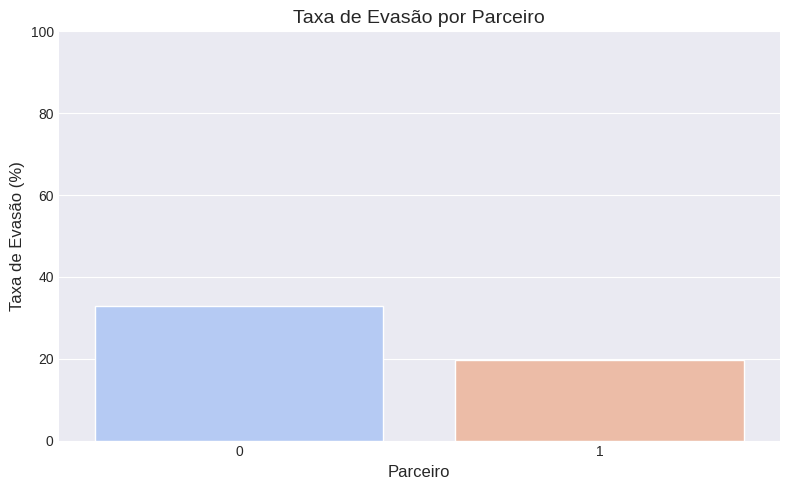

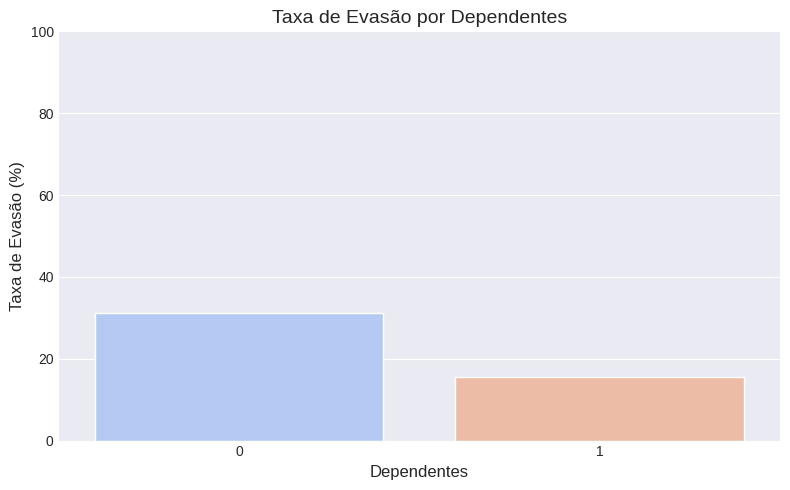

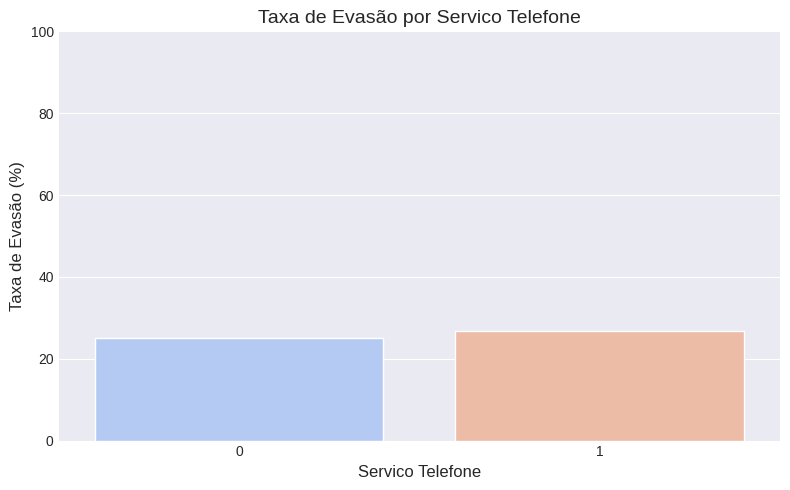

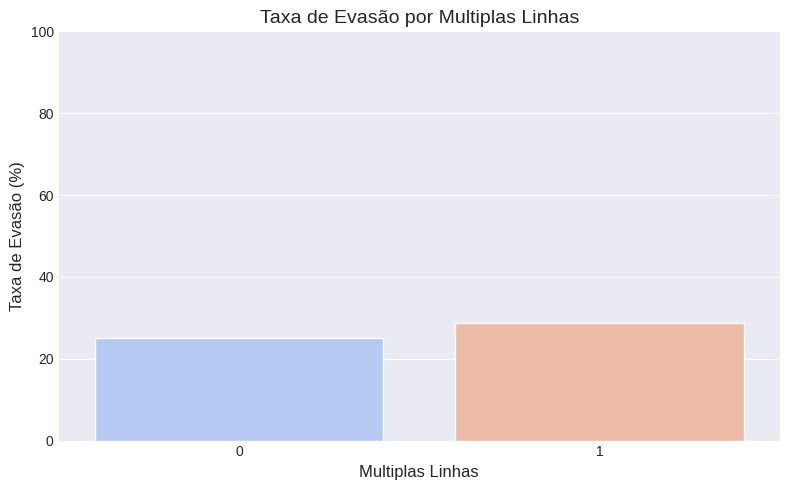

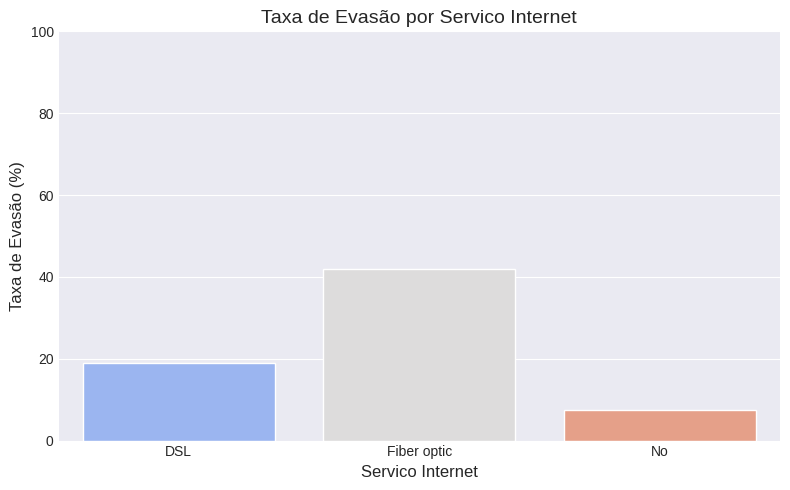

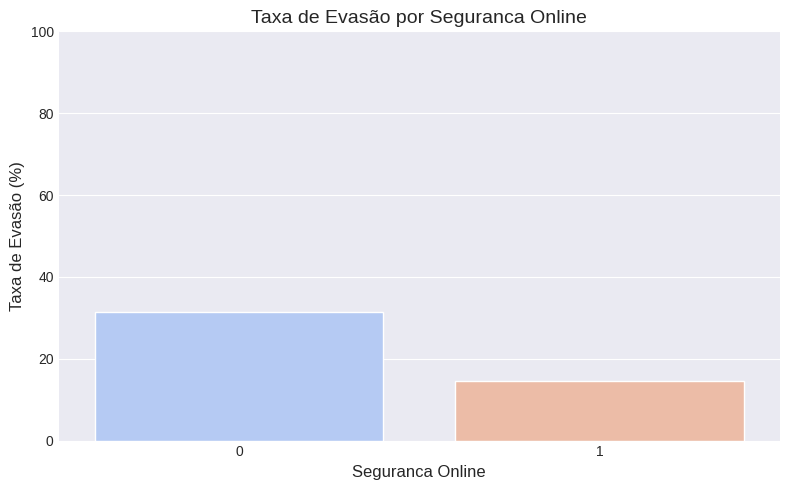

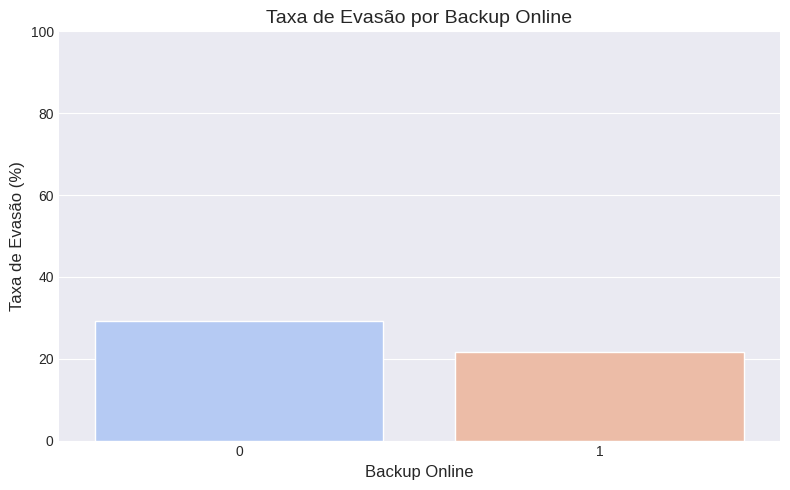

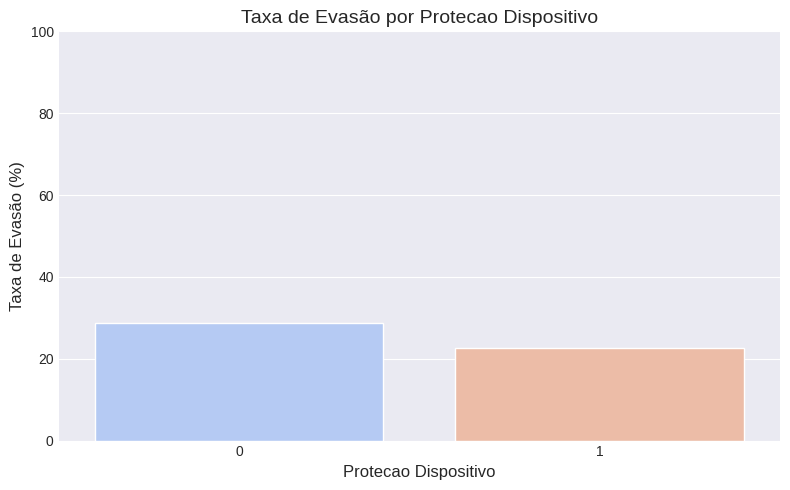

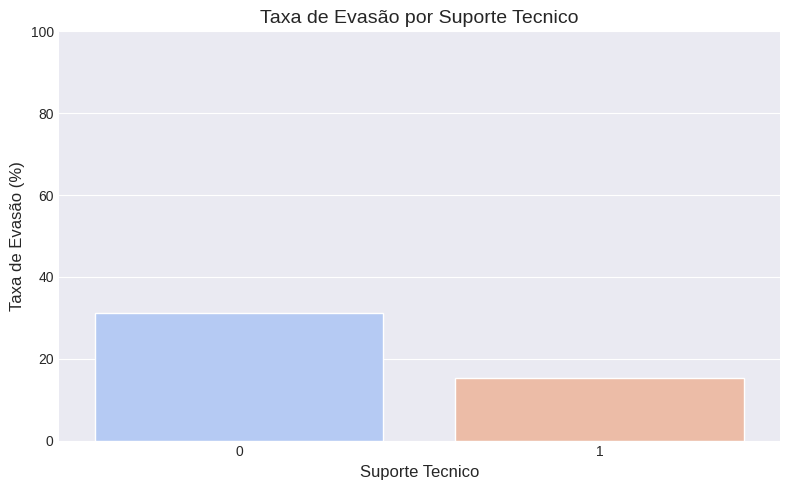

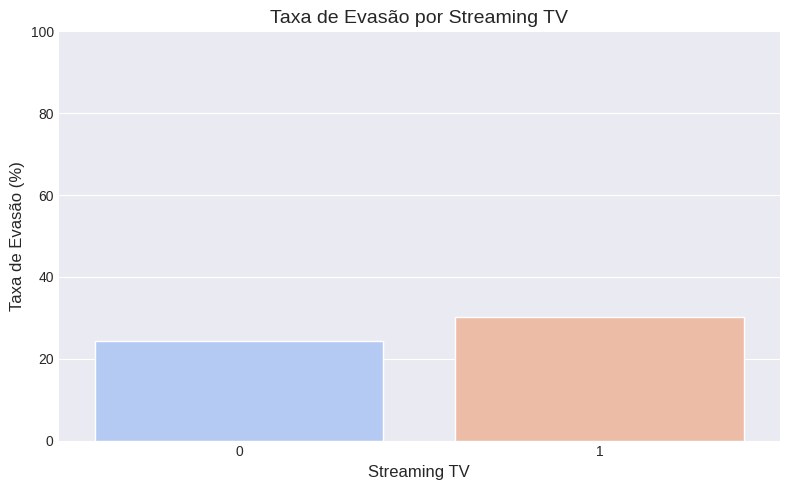

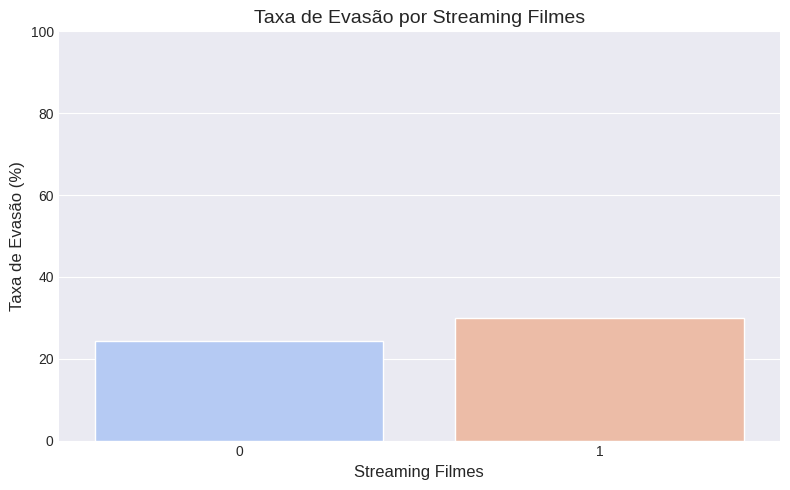

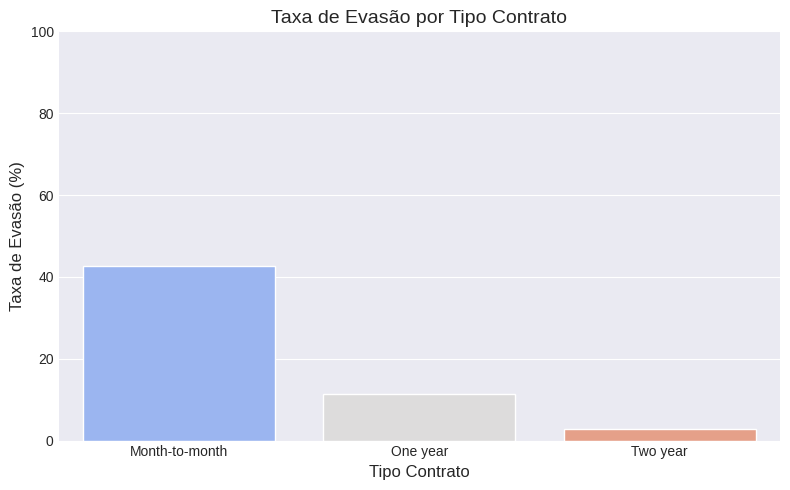

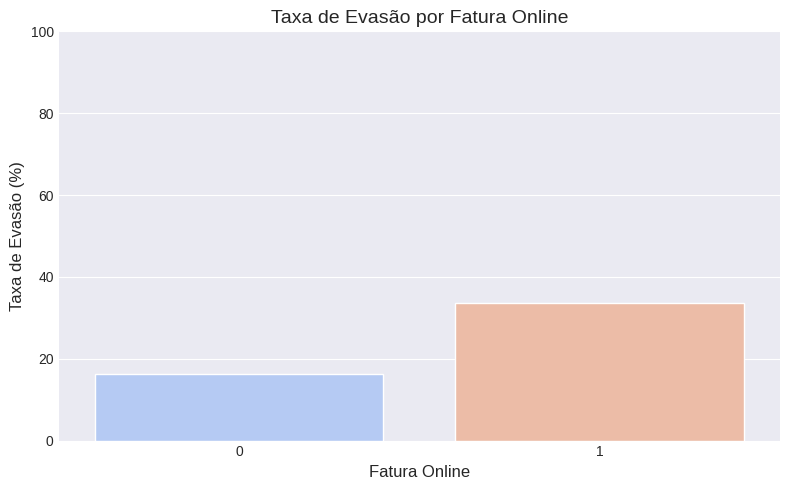

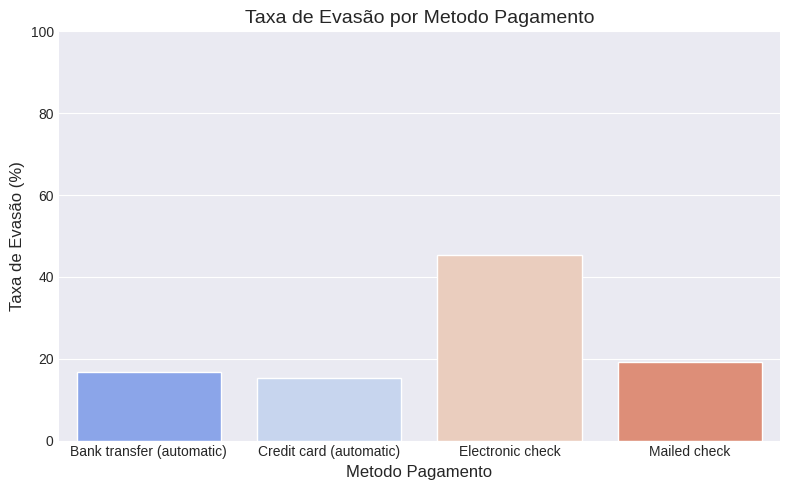

In [ ]:
# Lista de variáveis categóricas a serem analisadas em relação à Evasao
categorical_features = [
    'Genero', 'Cidadao_Senior', 'Parceiro', 'Dependentes',
    'Servico_Telefone', 'Multiplas_Linhas', 'Servico_Internet',
    'Seguranca_Online', 'Backup_Online', 'Protecao_Dispositivo',
    'Suporte_Tecnico', 'Streaming_TV', 'Streaming_Filmes',
    'Tipo_Contrato', 'Fatura_Online', 'Metodo_Pagamento'
]

# Configurar o estilo dos gráficos
sns.set_style("whitegrid")
plt.style.use("seaborn-v0_8-darkgrid")

# Gerar gráficos para cada variável categórica
for feature in categorical_features:
    if feature in df.columns and not df[feature].empty:
        plt.figure(figsize=(8, 5))

        # Calcular a taxa de churn (média de 'Evasao') por categoria
        churn_rate_by_category = df.groupby(feature)['Evasao'].mean().reset_index()
        churn_rate_by_category['Evasao_Percent'] = churn_rate_by_category['Evasao'] * 100

        sns.barplot(x=feature, y='Evasao_Percent', data=churn_rate_by_category, palette='coolwarm', hue=feature, legend=False)

        plt.title(f'Taxa de Evasão por {feature.replace("_", " ")}', fontsize=14)
        plt.xlabel(feature.replace("_", " "), fontsize=12)
        plt.ylabel('Taxa de Evasão (%)', fontsize=12)
        plt.xticks(fontsize=10)
        plt.yticks(fontsize=10)
        plt.ylim(0, 100)

        plt.tight_layout()
        plt.show()
    else:
        print(f"Aviso: Coluna '{feature}' não encontrada ou vazia para análise.")

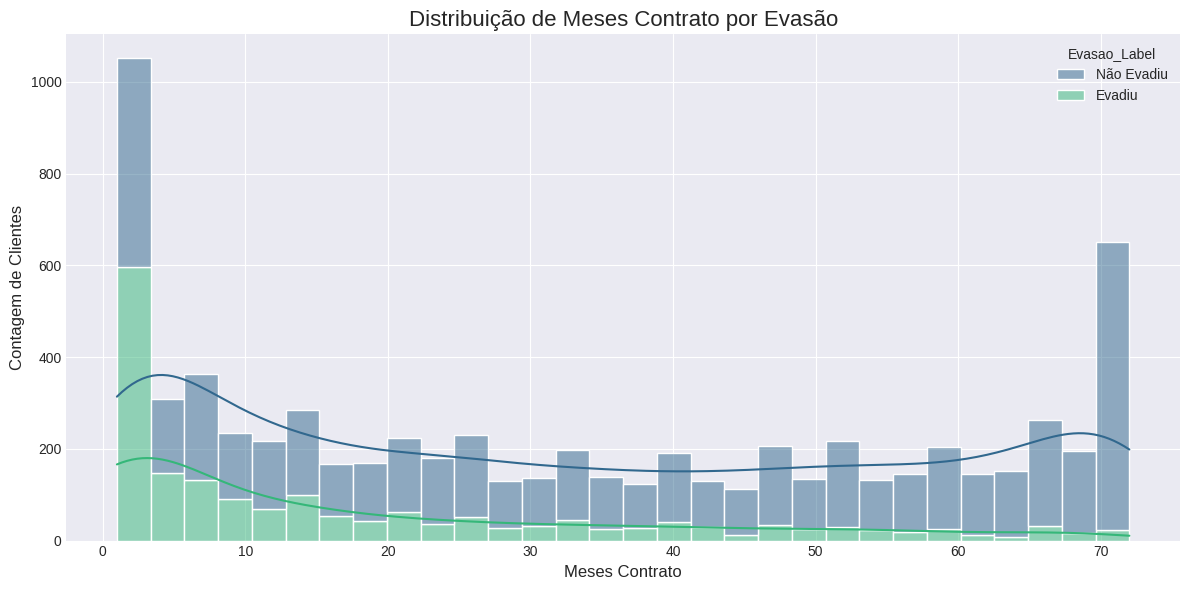

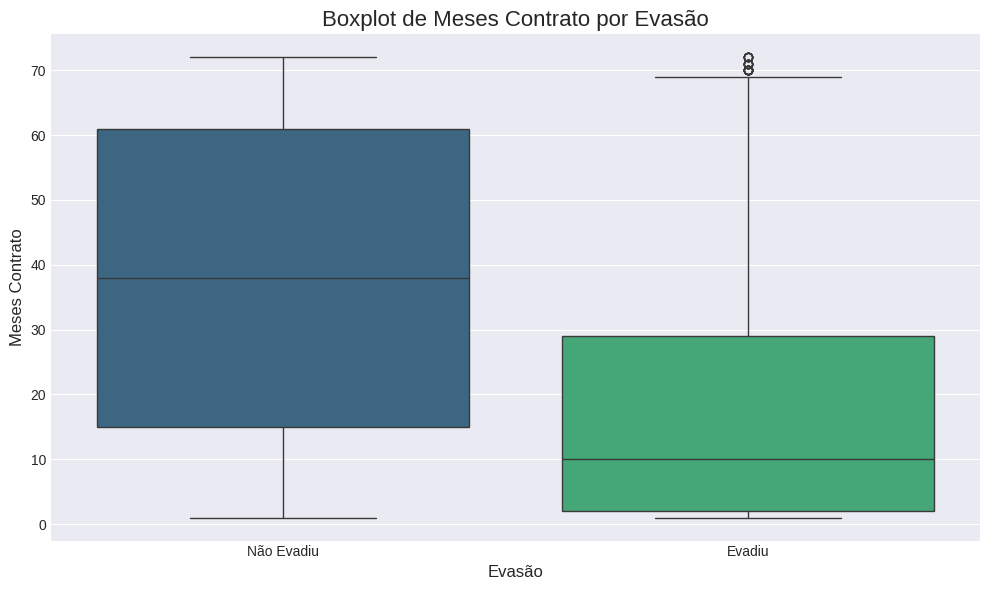

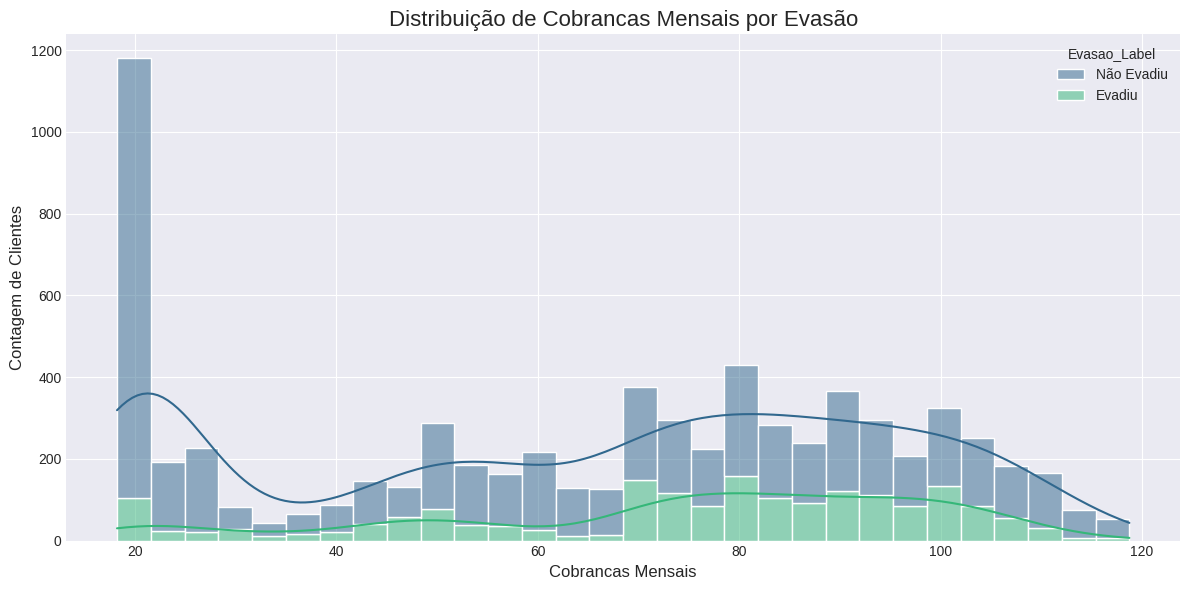

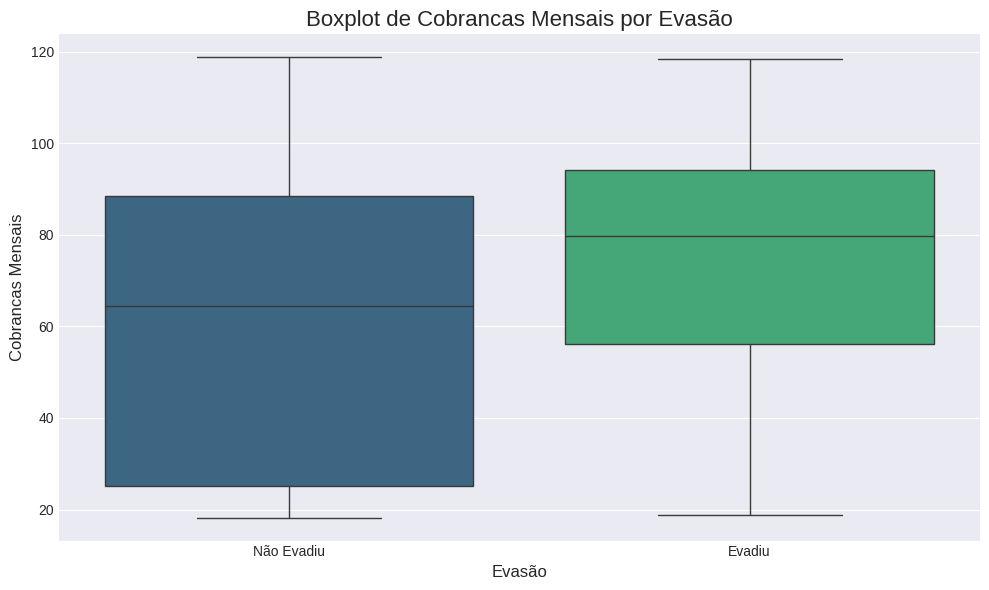

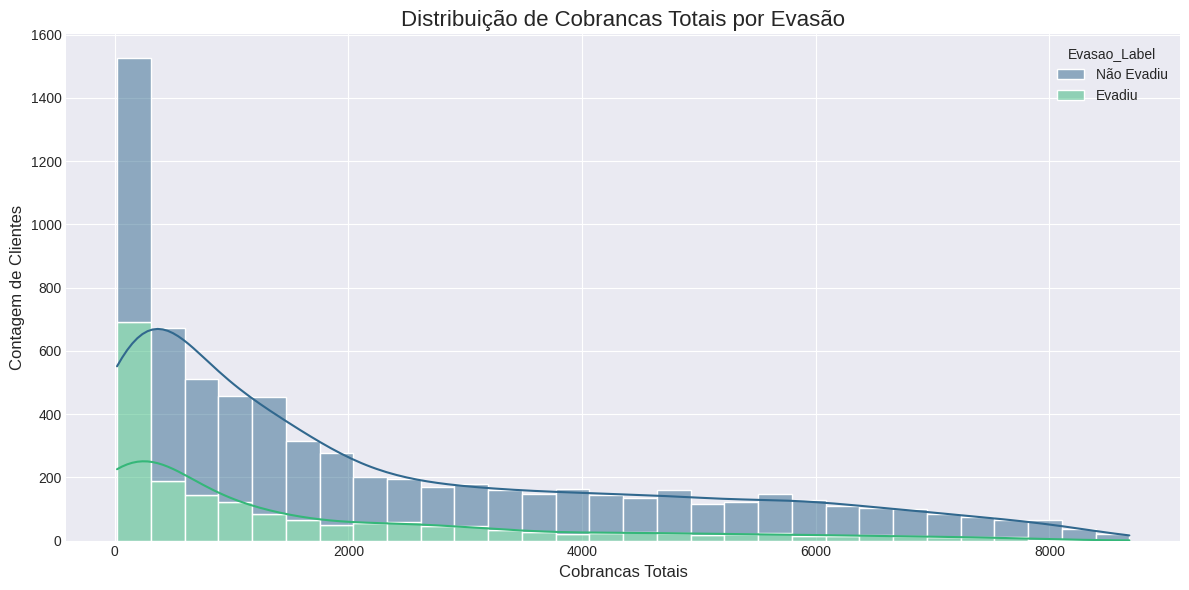

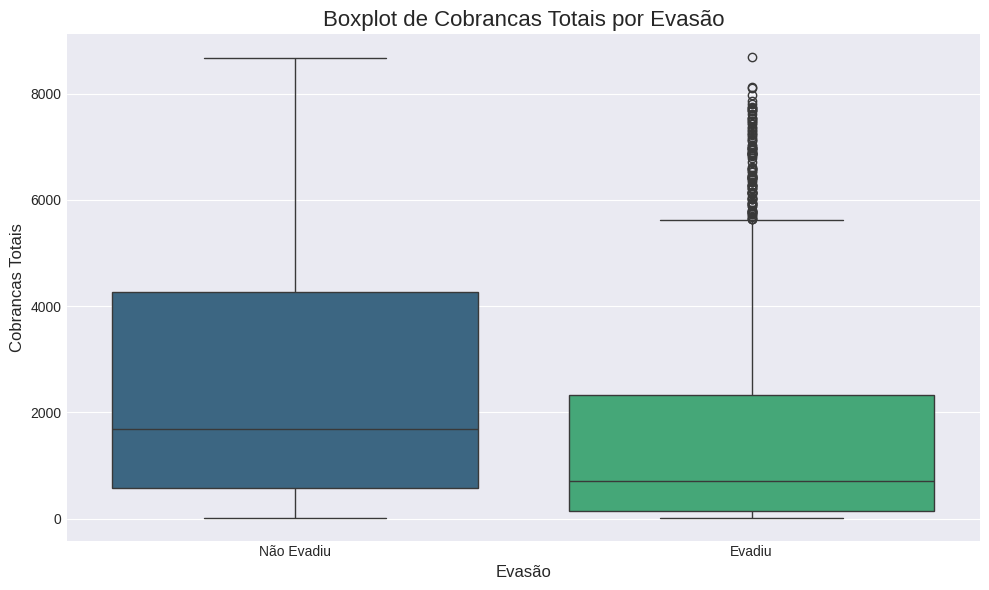

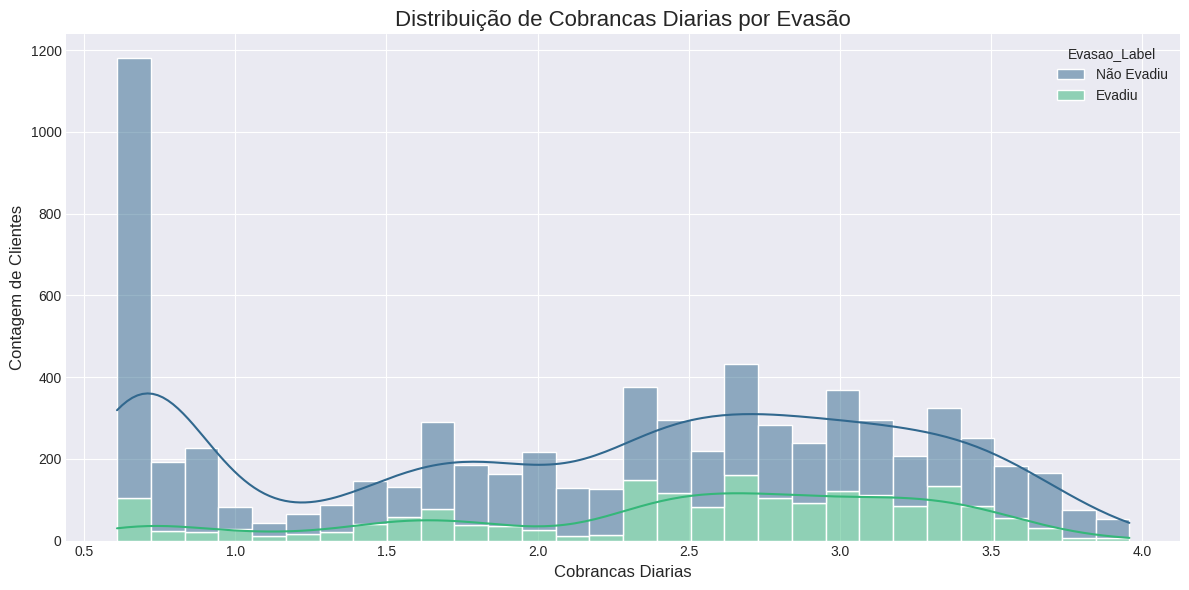

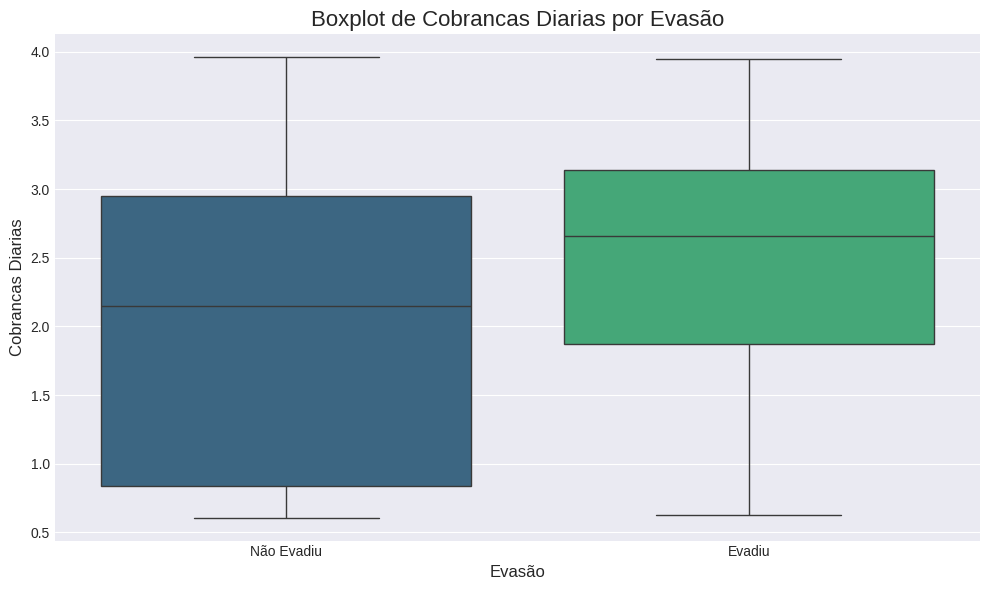

In [ ]:
numeric_features = [
    'Meses_Contrato',
    'Cobrancas_Mensais',
    'Cobrancas_Totais',
    'Cobrancas_Diarias'
]

# Configurar o estilo dos gráficos
sns.set_style("whitegrid")
plt.style.use("seaborn-v0_8-darkgrid")

# Criar uma coluna com rótulos para a legenda dos gráficos
# df['Evasao'] já é 0 ou 1
# Certifica-se de que Evasao_Label exista, se não, cria.
if 'Evasao_Label' not in df.columns:
    df['Evasao_Label'] = df['Evasao'].map({0: 'Não Evadiu', 1: 'Evadiu'})

# Gerar gráficos para cada variável numérica
for feature in numeric_features:
    if feature in df.columns and not df[feature].empty and df[feature].dtype != 'object':
        # Histograma (distribuição)
        plt.figure(figsize=(12, 6))
        sns.histplot(data=df, x=feature, hue='Evasao_Label', multiple='stack', palette='viridis', kde=True, bins=30)
        plt.title(f'Distribuição de {feature.replace("_", " ")} por Evasão', fontsize=16)
        plt.xlabel(feature.replace("_", " "), fontsize=12)
        plt.ylabel('Contagem de Clientes', fontsize=12)
        plt.xticks(fontsize=10)
        plt.yticks(fontsize=10)
        plt.tight_layout()
        plt.show()

        # Boxplot (comparação de quartis e outliers)
        plt.figure(figsize=(10, 6))
        sns.boxplot(x='Evasao_Label', y=feature, data=df, palette='viridis', hue='Evasao_Label', legend=False) # Adicionado hue e legend=False
        plt.title(f'Boxplot de {feature.replace("_", " ")} por Evasão', fontsize=16)
        plt.xlabel('Evasão', fontsize=12)
        plt.ylabel(feature.replace("_", " "), fontsize=12)
        plt.xticks(fontsize=10)
        plt.yticks(fontsize=10)
        plt.tight_layout()
        plt.show()

    else:
        print(f"Aviso: Coluna numérica '{feature}' não encontrada, vazia ou não numérica no DataFrame.")

#📄Relatorio Final

# **Relatório de Análise de Evasão de Clientes (Churn) - Telecom X**

### **1. Introdução**

Este relatório apresenta os resultados da análise inicial sobre o fenômeno de evasão de clientes (Churn) na Telecom X. O principal objetivo é compreender os fatores que levam os clientes a cancelar seus serviços, fornecendo insights valiosos para a equipe de Data Science e para a formulação de estratégias de retenção.

A evasão de clientes representa uma perda significativa de receita e um custo elevado para a aquisição de novos clientes. Entender "por que" e "quem" está evadindo é o primeiro passo para mitigar esse problema e otimizar a sustentabilidade do negócio.

---

### **2. Limpeza e Tratamento de Dados (Processo ETL)**

A fase de preparação dos dados foi crucial para garantir a qualidade e a consistência das informações utilizadas na análise. As principais etapas realizadas foram:

* **Extração:** Os dados foram carregados diretamente de um arquivo JSON disponível via API do GitHub.
* **Achatamento (Flattening):** A estrutura original do JSON continha dados aninhados (informações do cliente, telefone, internet, conta). Implementamos um processo manual de achatamento para transformar esses dados em um formato tabular plano, onde cada característica (coluna) é diretamente acessível, evitando problemas com dados complexos.
* **Limpeza e Padronização:**
    * **`Cobrancas_Totais` e `Cobrancas_Mensais`:** Convertidas para o tipo numérico. Valores inválidos ou vazios foram tratados como `NaN` e as linhas correspondentes a `NaN` em `Cobrancas_Totais` (geralmente clientes muito novos) foram removidas.
    * **`Evasao` (Coluna Alvo):** Mapeada de 'Yes'/'No' para 1/0, respectivamente, e linhas com `NaN` nesta coluna foram removidas para garantir a integridade da variável a ser predita.
    * **Serviços com "No service":** Valores como "No phone service" ou "No internet service" foram padronizados para "No" para manter a consistência entre as colunas de serviço.
    * **Variáveis Binárias:** Colunas como `Parceiro`, `Dependentes`, `Fatura_Online`, `Servico_Telefone` e os serviços de internet/streaming (que tinham 'Yes'/'No') foram convertidas para 1 (Sim) e 0 (Não). A coluna `Genero` ('Female'/'Male') também foi convertida para 1/0. `Cidadao_Senior` (originalmente 0/1) foi mantida como 0/1.
    * **Remoção de Duplicatas:** Foram removidas linhas totalmente duplicadas, bem como IDs de clientes duplicados para garantir que cada linha representasse um cliente único.
* **Criação de Novas Features:** Uma nova coluna, `Cobrancas_Diarias`, foi criada dividindo `Cobrancas_Mensais` por 30, oferecendo uma perspectiva diária de custo.
* **Renomeamento de Colunas:** Todas as colunas tiveram seus nomes traduzidos para português e padronizados para o formato snake_case (e.g., `Charges.Monthly` para `Cobrancas_Mensais`, `Churn` para `Evasao`), melhorando a compreensão.

Com essas etapas, o dataset está agora limpo, padronizado e pronto para análises aprofundadas.

---

### **3. Análise Exploratória de Dados (EDA)**

A EDA foi focada em entender a distribuição da evasão e sua relação com as demais variáveis.

#### **3.1. Distribuição da Evasão (Churn)**

A análise inicial revela que a taxa de evasão na Telecom X é de aproximadamente **26.54%**. Isso indica que uma parcela considerável dos clientes está cancelando os serviços, reforçando a importância e a urgência deste projeto para a empresa.

*Visualização da Distribuição de Clientes por Evasão (Churn) - Gráfico de Barras:*
(Imagine um gráfico de barras com duas barras: "Não Evadiu" (aproximadamente 5174 clientes) e "Evadiu" (aproximadamente 1869 clientes), mostrando as respectivas porcentagens.)

*Visualização da Proporção de Clientes Evadidos vs. Não Evadidos - Gráfico de Pizza:*
(Imagine um gráfico de pizza dividido em duas fatias: uma maior para "Não Evadiu" (aprox. 73.46%) e uma menor para "Evadiu" (aprox. 26.54%).)

#### **3.2. Evasão por Variáveis Categóricas**

A exploração da taxa de evasão por diferentes categorias revelou padrões interessantes:

* **Tipo de Contrato (`Tipo_Contrato`):** Clientes com contrato **mensal** tendem a ter uma taxa de evasão significativamente **mais alta** (chegando a aproximadamente 43-44%) do que aqueles com contratos anuais (cerca de 11%) ou bienais (cerca de 3%). Isso é esperado, pois contratos de curto prazo oferecem maior flexibilidade para cancelar.
* **Serviço de Internet (`Servico_Internet`):** Clientes com **fibra óptica** (com taxa de evasão de aproximadamente 42%) apresentam uma taxa de evasão maior comparado a clientes com DSL (cerca de 19%) ou àqueles sem serviço de internet (aprox. 7%). Isso pode indicar problemas de qualidade ou custo percebido para este tipo de serviço.
* **Serviços Adicionais (e.g., `Seguranca_Online`, `Suporte_Tecnico`):** Clientes que **não assinam** serviços adicionais como segurança online (aprox. 41% de evasão) ou suporte técnico (aprox. 41% de evasão) parecem ter uma **maior taxa de evasão**. Isso sugere que esses serviços agregam valor e contribuem para a retenção do cliente.
* **Método de Pagamento (`Metodo_Pagamento`):** Métodos de pagamento como **cheque eletrônico** (com taxa de evasão próxima de 45%) estão associados a uma **taxa de evasão mais elevada** do que outros métodos como cheque enviado pelo correio (aprox. 19%) ou transferência bancária (aprox. 16%).
* **Fatura Online (`Fatura_Online`):** Clientes que optam por **Fatura Online** tendem a evadir mais (cerca de 33%) do que aqueles que recebem faturas impressas (cerca de 16%).

*(Para cada um dos itens acima, imagine um gráfico de barras comparando a Taxa de Evasão (%) entre as categorias da variável, com a barra da categoria de maior evasão se destacando.)*

#### **3.3. Evasão por Variáveis Numéricas**

A análise da distribuição de variáveis numéricas entre clientes que evadem e não evadem forneceu insights sobre o comportamento de gastos e tempo de permanência:

* **Meses de Contrato (`Meses_Contrato`):** Os histogramas e boxplots mostram claramente que clientes com **menor tempo de contrato** (especialmente nos primeiros poucos meses) apresentam uma concentração muito maior de evasão. A mediana de `Meses_Contrato` para clientes que evadiram é significativamente menor do que para aqueles que não evadiram. Isso sugere que os primeiros meses de serviço são críticos para a retenção.
* **Cobrancas Mensais (`Cobrancas_Mensais`):** A evasão é notavelmente maior entre clientes que pagam **Cobrancas_Mensais** mais altas (especialmente aqueles na faixa dos $80 a $100), geralmente associados a serviços de fibra óptica e vários adicionais. No entanto, o boxplot também pode revelar um grupo com cobranças mensais muito baixas que evadem.
* **Cobrancas Totais (`Cobrancas_Totais`):** Clientes com **Cobrancas_Totais** acumuladas menores são mais propensos a evadir. Isso se correlaciona diretamente com o `Meses_Contrato` baixo, indicando que clientes de curta duração e baixo gasto total são os de maior risco.

*(Para cada um dos itens acima, imagine um par de gráficos: um Histograma mostrando a distribuição da variável numérica para "Não Evadiu" e "Evadiu", e um Boxplot comparando a mediana e a dispersão entre os dois grupos de evasão.)*

---

### **4. Conclusões e Insights**

A análise exploratória de dados revelou vários insights importantes sobre a evasão de clientes na Telecom X:

* **Alta Vulnerabilidade de Clientes Novos e de Curto Prazo:** Os primeiros meses de contrato são críticos. Clientes com `Meses_Contrato` baixo e, consequentemente, `Cobrancas_Totais` baixas, têm alta probabilidade de evasão.
* **Risco Associado a Contratos Mensais:** Clientes em contratos "mês a mês" são o segmento de maior risco, provavelmente devido à facilidade de cancelamento.
* **Impacto dos Serviços de Internet e Adicionais:** A evasão é maior entre clientes com Fibra Óptica (sugerindo possíveis problemas de serviço ou preço nesse segmento) e, paradoxalmente, entre aqueles que **não** contratam serviços de segurança online ou suporte técnico, indicando a importância desses adicionais para a "adesão" e valor percebido.
* **Método de Pagamento como Indicador:** O pagamento via cheque eletrônico está correlacionado com maior evasão, o que pode apontar para problemas na experiência de pagamento ou um perfil de cliente de alto risco associado a esse método.
* **Perfil do Cliente que Evade:** É um cliente frequentemente novo, com contrato mensal, possivelmente com fibra óptica, que não adquire serviços adicionais e usa cheque eletrônico como método de pagamento.

Esses achados são fundamentais para entender o perfil do cliente que evade e onde a Telecom X pode ter oportunidades de intervenção estratégica.

---

### **5. Recomendações**

Com base nas conclusões da análise, sugiro as seguintes recomendações para a Telecom X:

1.  **Programas de Retenção para Clientes Recém-Adquiridos:** Implementar um acompanhamento proativo e ofertas personalizadas nos primeiros 3-6 meses de contrato, especialmente para clientes com contratos mensais. Isso pode incluir descontos iniciais, melhorias de serviço ou comunicação direcionada.
2.  **Incentivos para Contratos de Longo Prazo:** Criar programas de fidelidade ou descontos progressivos para encorajar a migração de clientes de contratos mensais para anuais ou bienais, aumentando o compromisso e a lealdade.
3.  **Avaliação e Melhoria do Serviço de Fibra Óptica:** Investigar as causas da alta taxa de evasão entre clientes de fibra óptica. Pode ser necessário melhorar a qualidade do serviço, a estabilidade da conexão ou a comunicação sobre o valor.
4.  **Promoção Estratégica de Serviços Adicionais:** Aumentar os esforços de marketing e vendas para que clientes contratem serviços como segurança online e suporte técnico. Destacar os benefícios desses serviços para aumentar a percepção de valor e a "adesão" ao ecossistema da Telecom X.
5.  **Otimização da Experiência de Pagamento:** Investigar a jornada do cliente que utiliza cheque eletrônico para identificar e remover possíveis pontos de atrito. Considerar incentivar métodos de pagamento mais automatizados e confiáveis (débito automático, cartão de crédito).
6.  **Segmentação para Campanhas de Retenção:** Utilizar o perfil de cliente de alto risco identificado (e.g., contrato mensal, fibra óptica, sem adicionais, cheque eletrônico, poucos meses de contrato) para criar campanhas de retenção altamente segmentadas e personalizadas, oferecendo soluções que abordem suas vulnerabilidades específicas.

Este relatório serve como uma base sólida para a equipe de Data Science avançar na construção de modelos preditivos e para que a Telecom X desenvolva estratégias eficazes e baseadas em dados para combater a evasão de clientes.